# Movie to Book Recommendation Engine

Throughout my life, I have always intended to read more books, but taking recommendations based on similar books proves ineffective due to my lack of reading history. However, I have watched an extensive number of films via theatres and Netflix, so I wonder: could tastes established in viewing films transfer to help determine which books I might like? An effective book recommender based on movie tastes could prove quite lucrative to the book publishing industry, drawing on peer recommendations and user’s own personal input to drive book sales and higher user engagement with the more active literature community.

A movie-to-book recommendation engine seeks to deliver a way for less active readers to breach the reading barrier, using item-to-item collaborative filtering to find book titles agreeing with film taste. Using the [Movielens 20M dataset](https://github.com/zygmuntz/goodbooks-10k) and [Goodreads](https://www.kaggle.com/rounakbanik/the-movies-dataset) book review dataset, a similarity model that first focuses on genres and keywords NLP of movies/books to recommend titles similar to the user’s choices, then focuses on users that liked similar content to recommend more peer-approved choices. To keep data sources updated, two web scrapers will extract new titles and reviews from each respective data source using the Goodreads and TMDB APIs in order to retrain and expand the model's capabilities.

In [1]:
#Imports & settings
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from ast import literal_eval
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
#Ignore SettingWithCopyWarning for false positives
pd.options.mode.chained_assignment = None
import sys, os
from contextlib import contextmanager
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xml.parsers.expat import ExpatError
import xmltodict
from collections import OrderedDict 
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import bs4 as bs
import requests
from urllib.parse import urljoin

In [2]:
#Movie Dataframes to be merged
metadata= pd.read_csv('Downloads/the-movies-dataset/movies_metadata.csv', low_memory=False)
movie_ratings= pd.read_csv('Downloads/the-movies-dataset/ratings.csv')
links= pd.read_csv('Downloads/the-movies-dataset/links.csv')
keywords= pd.read_csv('Downloads/the-movies-dataset/keywords.csv')

In [3]:
#Book DataFrames
booktags= pd.read_csv('Downloads/goodbooks-10k/book_tags.csv')
books= pd.read_csv('Downloads/goodbooks-10k/books.csv')
book_ratings= pd.read_csv('Downloads/goodbooks-10k/ratings.csv')
translations= pd.read_csv('Downloads/goodbooks-10k/tags.csv')
toread= pd.read_csv('Downloads/goodbooks-10k/to_read.csv')

In [4]:
print('Booktags shape: ', booktags.shape)
print('Books shape: ', books.shape)
print('Book Ratings shape: ', book_ratings.shape)
print('Translations shape: ', translations.shape)
print('To-Read shape: ', toread.shape)

Booktags shape:  (999912, 3)
Books shape:  (10000, 23)
Book Ratings shape:  (5976479, 3)
Translations shape:  (34252, 2)
To-Read shape:  (912705, 2)


In [5]:
#Display tables side by side in following cell

CSS = '''
div.cell:nth-child(5) .output {
    flex-direction: row;
}
'''

HTML('<style>{}</style<>'.format(CSS))

display(booktags.head())
display(translations.tail())
display(book_ratings.head())

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


,tag_id,tag_name
34247,34247,Ｃhildrens
34248,34248,Ｆａｖｏｒｉｔｅｓ
34249,34249,Ｍａｎｇａ
34250,34250,ＳＥＲＩＥＳ
34251,34251,ｆａｖｏｕｒｉｔｅｓ


,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [6]:
books.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [7]:
#Drop all unnecesary info
books= books.drop(columns=['books_count', 'isbn13', 'original_publication_year', 'original_title', 
                   'language_code', 'ratings_count', 'isbn', 'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 
                   'ratings_5', 'small_image_url'])

In [8]:
book_ratings.groupby('book_id').mean().describe()

,user_id,rating
count,10000.000000,10000.000000
mean,26872.968977,3.903136
std,4402.068832,0.285346
min,8013.653333,2.077966
25%,24003.549483,3.728160
50%,26734.126908,3.922021
75%,29456.678858,4.097793
max,47143.496000,4.829876


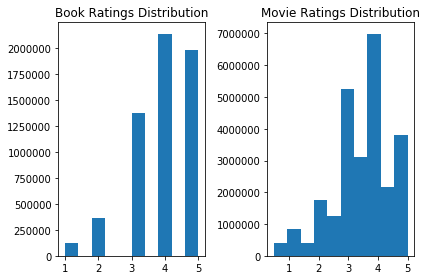

In [9]:
plt.subplot(1, 2, 1)
plt.hist(book_ratings.rating)
plt.title('Book Ratings Distribution')
plt.xticks([1, 2, 3, 4, 5])

plt.subplot(1, 2, 2)
plt.hist(movie_ratings.rating)
plt.title('Movie Ratings Distribution')
plt.xticks([1, 2, 3, 4, 5])

plt.tight_layout()

Book ratings have an integer distribution, while movie ratings have values at each 0.5 mark in the same range, with both distributions following a similar curve peaking at 4 and very few negative ratings below 3.  

In [10]:
#Extract genres from Series with max 5 genres
def get_genres(x):
    if isinstance(x, list):
        names= [i['name'] for i in x]
        
        if len(names) > 5:
            names = names[:5]
        return names
    
    return []

metadata['genres']=metadata.genres.apply(literal_eval)
metadata['genres']=metadata.genres.apply(get_genres)         

In [11]:
#Use function with no max limit

def get_keywords(x):
    if isinstance(x, list):
        names= [i['name'] for i in x]
        return names
    return []
    

keywords['keywords']=keywords.keywords.apply(literal_eval)
keywords['keywords']=keywords.keywords.apply(get_keywords)
keywords.head()

,id,keywords
0,862,"[jealousy, toy, boy, friendship, friends, riva..."
1,8844,"[board game, disappearance, based on children'..."
2,15602,"[fishing, best friend, duringcreditsstinger, o..."
3,31357,"[based on novel, interracial relationship, sin..."
4,11862,"[baby, midlife crisis, confidence, aging, daug..."


In [12]:
#Loop to join keywords 
for i in range(len(keywords.keywords)):
    keywords.keywords.iloc[i]=[x.replace(' ', '-') for x in keywords.keywords[i]]   
#Transform to bag-of-words format
keywords.keywords = keywords.keywords.apply(' '.join)

In [13]:
#No adult films
metadata = metadata[metadata.adult=='False']

#Merge Keywords
metadata.id = metadata.id.astype(int)
metadata = metadata.join(keywords.set_index('id'), on ='id', how ='left')

#Drop any unreleased films
metadata = metadata[metadata.status == 'Released']

#Convert to numeric
metadata.popularity = pd.to_numeric(metadata.popularity)

#Drop unnecessary columns after filters applied
metadata = metadata.drop(
    columns = ['adult', 'belongs_to_collection', 'budget', 'homepage', 'revenue', 'runtime',
             'video', 'tagline', 'original_title', 'production_companies',
             'production_countries', 'release_date', 'overview', 'spoken_languages', 
             'status', 'vote_average', 'vote_count', 
                      ]
)

In [14]:
#Drop duplicates from join
metadata.iloc[metadata.id.drop_duplicates().index].reset_index(drop=True, inplace = True)

#Find Missing keywords
missing_keys = metadata[metadata.keywords.isnull()].index[0]
#1 NaN found: drop
metadata = metadata.drop(missing_keys).reset_index(drop=True)

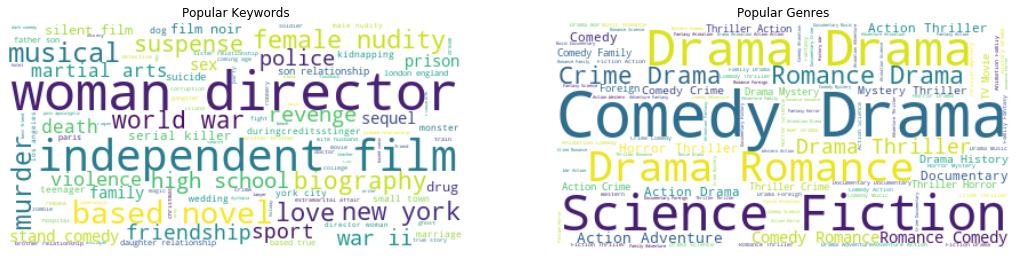

In [15]:
#Explore genres and keywords
genres = ' '.join(metadata.genres.apply(' '.join))
keys = ' '.join(metadata.keywords)
wordcloud_keys = WordCloud(max_font_size = 80, max_words = 100, background_color = 'white').generate(keys)
wordcloud_genres = WordCloud(max_font_size = 80, max_words = 100, background_color = 'white').generate(genres)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 18))
ax1.imshow(wordcloud_keys, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Popular Keywords')
ax2.imshow(wordcloud_genres, interpolation='bilinear')
ax2.set_title('Popular Genres')
ax2.axis('off')

plt.show()

In [16]:
#Fit TF-idf to movieset
tf_movie = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), stop_words='english')
tfidf_matrix_movie = tf_movie.fit_transform(metadata['keywords'])
cosine_sim_movie = linear_kernel(tfidf_matrix_movie, tfidf_matrix_movie)

In [17]:
#1-D array of movie titles
movie_titles=metadata['title']
mov_ind= pd.Series(metadata.index, index=metadata['title'])

#Recommender function for tags only
def keyword_recs(title):
    idx = mov_ind[title]
    sim_scores = list(enumerate(cosine_sim_movie[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return movie_titles.iloc[movie_indices], sim_scores
keyword_recs('Jumanji')

(30079                                 The Games Maker
 31125                                           Stung
 41397                                           Bleed
 26375                                  Mostly Ghostly
 27562                            Karlsson on the Roof
 40680       Middle School: The Worst Years of My Life
 41654                              The Butterfly Ball
 14248                       Where the Wild Things Are
 30266    Mostly Ghostly: Have You Met My Ghoulfriend?
 40965                  Winnie-the-Pooh and a Busy Day
 Name: title, dtype: object,
 [(30079, 0.35930175448607043),
  (31125, 0.35506073614185624),
  (41397, 0.31807072494521044),
  (26375, 0.31013818475042654),
  (27562, 0.28827288909410537),
  (40680, 0.2703685212936458),
  (41654, 0.2402212649199111),
  (14248, 0.23833465385709326),
  (30266, 0.232473189657866),
  (40965, 0.22260996697217858)])

In [18]:
#Merge book IDs with tag descriptions
tagnames= booktags.join(translations.set_index('tag_id'), on='tag_id', how='left')

#To-read info held separately--drop here
tagnames=tagnames[tagnames.tag_name!='to-read']
tagnames.head()

,goodreads_book_id,tag_id,count,tag_name
1,1,11305,37174,fantasy
2,1,11557,34173,favorites
3,1,8717,12986,currently-reading
4,1,33114,12716,young-adult
5,1,11743,9954,fiction


In [19]:
#Combine tags for each book
grouped_tags=tagnames.groupby('goodreads_book_id')['tag_name'].apply(' '.join)

#Merge back into main DF
books=pd.merge(books, grouped_tags, on='goodreads_book_id')

In [20]:
#1-D Array of titles
titles1 = books['title']
indices1 = pd.Series(books.index, index=books['title'])
#New TFIDF Vectorizer for single tags
tf1 = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), stop_words='english')


#Recommender function movie to book -- tags only 
def movie_to_booktags(title):
    #Initialize row of movie 
    movie=pd.Series(index=books.columns)
    movie['title']= title
    movie_idx= metadata[metadata.title == title].index[0]
    movie['tag_name'] = metadata.iloc[movie_idx]['keywords']
    #Create temporary df using 
    temp_df = books.append(movie, ignore_index=True)
    #Retrain Model with temporary DF
    tfidf_matrix1 = tf1.fit_transform(temp_df['tag_name'])
    cosine_sim1 = linear_kernel(tfidf_matrix1, tfidf_matrix1)
    idx = 10000
    sim_scores = list(enumerate(cosine_sim1[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    book_indices = [i[0] for i in sim_scores]
    return titles1.iloc[book_indices], sim_scores
movie_to_booktags('Jumanji')

(3302                                 The Very Busy Spider
 9738                                 Halo: Ghosts of Onyx
 8176                                   Halo: First Strike
 5574                              Halo: The Fall of Reach
 6696                                       Barnyard Dance
 2511                          Mr. Brown Can Moo! Can You?
 3742                                  The Grouchy Ladybug
 4009    There Was An Old Lady Who Swallowed A Fly (Cla...
 8489                                      Halo: The Flood
 862                             Guess How Much I Love You
 Name: title, dtype: object,
 [(3302, 0.16281476072532597),
  (9738, 0.14102878404102273),
  (8176, 0.14048698834415044),
  (5574, 0.13897373524690096),
  (6696, 0.13378361518129295),
  (2511, 0.12464101406417287),
  (3742, 0.12394101840053288),
  (4009, 0.12192550964226388),
  (8489, 0.12185883789037753),
  (862, 0.12137823343595594)])

In [21]:
#Add genres to bag of words
metadata['genres'] = metadata.genres.apply(' '.join)

metadata['genrekeys'] = (pd.Series(metadata[['genres', 'keywords']]
                .fillna('')
                .values.tolist()
                ).str.join(' '))

In [22]:
#Tune movie-recommender to include genres and keywords
tf_movie1 = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), stop_words='english')
tfidf_matrix_movie1 = tf_movie1.fit_transform(metadata['genrekeys'][:int(len(metadata)/5)])
cosine_sim_movie1 = linear_kernel(tfidf_matrix_movie1, tfidf_matrix_movie1)

In [23]:
#Test new model 
#1-D array of movie titles
movie_titles=metadata['title']
mov_ind= pd.Series(metadata.index, index=metadata['title'])

#Recommender function for tags only
def genrekeys_recs(title):
    idx = mov_ind[title]
    sim_scores = list(enumerate(cosine_sim_movie1[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return movie_titles.iloc[movie_indices], sim_scores
genrekeys_recs('Jumanji')

(6775              The Cat in the Hat
 7528    The Wonderful Ice Cream Suit
 650        James and the Giant Peach
 2293                            Clue
 499                            North
 1316                  101 Dalmatians
 8887                           Alice
 1976      Return from Witch Mountain
 5142           First Men in the Moon
 4980               The Deadly Mantis
 Name: title, dtype: object,
 [(6775, 0.22101747613797554),
  (7528, 0.18662776791938146),
  (650, 0.1840899175546147),
  (2293, 0.16983663557402764),
  (499, 0.16964971252420463),
  (1316, 0.1672816445228018),
  (8887, 0.15018508274195608),
  (1976, 0.1305461048593463),
  (5142, 0.12589494675335244),
  (4980, 0.12071332832397319)])

In [24]:
#1-D Array of titles
titles1 = books['title']
indices1 = pd.Series(books.index, index=books['title'])

#Recommender function for tags only
def genrekey_recs(title):
    #Initialize row of movie 
    movie=pd.Series(index=books.columns)
    movie['title']= title
    movie_idx= metadata[metadata.title == title].index[0]
    movie['tag_name'] = metadata.iloc[movie_idx]['genrekeys']
    #Create temporary df using new row
    temp_df = books.append(movie, ignore_index=True)
    #Retrain Model with temporary DF
    tfidf_matrix1 = tf1.fit_transform(temp_df['tag_name'])
    cosine_sim1 = linear_kernel(tfidf_matrix1, tfidf_matrix1)
    #Movie index 
    idx = 10000
    sim_scores = list(enumerate(cosine_sim1[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    book_indices = [i[0] for i in sim_scores]
    return titles1.iloc[book_indices], sim_scores
genrekey_recs('GoldenEye')

(5961    If You're Reading This, It's Too Late (Secret,...
 2732         The Name of This Book Is Secret (Secret, #1)
 6748           This Book Is Not Good for You (Secret, #3)
 6864                                       The Gun Seller
 302                           The Secret (The Secret, #1)
 6342       The Forever of Ella and Micha (The Secret, #2)
 9259                           The Magic (The Secret, #3)
 6530    The Initiation / The Captive Part I (The Secre...
 7696    The Captive Part II / The Power (The Secret Ci...
 4517                           The Power (The Secret, #2)
 Name: title, dtype: object,
 [(5961, 0.19876540813652593),
  (2732, 0.19417695481226946),
  (6748, 0.19233690405449655),
  (6864, 0.11635715806972491),
  (302, 0.11594649632168318),
  (6342, 0.11253994980884918),
  (9259, 0.11117954343847063),
  (6530, 0.108670605280793),
  (7696, 0.0978403113767546),
  (4517, 0.0968377945027029)])

## User-based Recommendation System

In [25]:
#Function to keep all IMDB ids 9 chars long with 'tt' prefix 
def rename_links(link):
    link = str(link)
    while len(link) < 7:
        link = '0' + link
    else:
        link = 'tt' + link
    return link     
links['imdbId'] = links.imdbId.apply(rename_links)
#Merge all IDs with movie ratings 
movie_ratings = movie_ratings.merge(links[['movieId', 'tmdbId', 'imdbId']], 
                                    on='movieId').drop(columns='timestamp')
#FIll NAs while preserving column type
movie_ratings['tmdbId'] = movie_ratings['tmdbId'].fillna(-1)
movie_ratings['tmdbId'] = movie_ratings['tmdbId'].astype('int64')

In [26]:
#Merge genres into ratings DF
movie_ratings = movie_ratings.merge(
    metadata[['genres', 'id']].set_index('id'), 
    how='left', left_on='tmdbId', right_on='id')

movie_ratings = movie_ratings.dropna()

In [27]:
#Explains tfidf params
tf4 = TfidfVectorizer(min_df=2, # only use words that appear at least twice
                         ngram_range=(1, 2), #Include bigrams and unigrams
                         stop_words='english', 
                         lowercase=True, 
                         use_idf=True,#Stronger weights for less frequent matches
                         smooth_idf=True #Adds 1 to all document frequencies to prevent divide-by-zero errors
                        )
tfidf_matrix4 = tf4.fit_transform(metadata['genres'][:int(len(metadata)/5)])
cosine_sim_movie4 = linear_kernel(tfidf_matrix4, tfidf_matrix4)

In [28]:
#1-D Array of titles
titles1 = books['title']
indices1 = pd.Series(books.index, index=books['title'])

#Recommender function movie to book -- tags only 
def genres_to_booktags(title):
    #Initialize row of movie 
    movie=pd.Series(index=books.columns)
    movie['title']= title
    movie_idx= metadata[metadata.title == title].index[0]
    movie['tag_name'] = metadata.iloc[movie_idx]['genrekeys']
    #Create temporary df using 
    temp_df = books.append(movie, ignore_index=True)
    #Retrain Model with temporary DF
    tfidf_matrix1 = tf1.fit_transform(temp_df['tag_name'])
    cosine_sim1 = linear_kernel(tfidf_matrix1, tfidf_matrix1)
    idx = 10000
    sim_scores = list(enumerate(cosine_sim1[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    book_indices = [i[0] for i in sim_scores]
    return titles1.iloc[book_indices], sim_scores
genres_to_booktags('Avatar')

(3115     A Million Suns (Across the Universe, #2)
 5659    Shades of Earth (Across the Universe, #3)
 3032                              The Right Stuff
 7765                               Absolution Gap
 9776                                Half Way Home
 8293                          The Android's Dream
 6339      Shards of Honour  (Vorkosigan Saga, #1)
 5427               Dauntless (The Lost Fleet, #1)
 8134                Fearless (The Lost Fleet, #2)
 3110                             Revelation Space
 Name: title, dtype: object,
 [(3115, 0.22262965514400065),
  (5659, 0.21769140749122512),
  (3032, 0.19867576393791908),
  (7765, 0.19210424282831196),
  (9776, 0.1899593881181263),
  (8293, 0.18987502048438942),
  (6339, 0.189287282320041),
  (5427, 0.18745160091350577),
  (8134, 0.1864380324817342),
  (3110, 0.18511152548826668)])

In [29]:
#Introduce weighted genre keywords
def weighted_recs(title):
    #Initialize row of movie 
    movie=pd.Series(index=books.columns)
    movie['title']= title
    movie_idx= metadata[metadata.title == title].index[0]
    movie['tag_name'] = metadata.iloc[movie_idx]['genrekeys']
    #Create temporary df using 
    temp_df = books.append(movie, ignore_index=True)
    #Retrain Model with temporary DF
    tfidf_matrix = tf4.fit_transform(temp_df['tag_name'])
    #Triple weight of genre words
    genres = list(''.join(
        metadata[metadata.title == title]['genres']
    ).lower().split()
                 )
    for key in movie.tag_name.lower().split():
        if key in genres:
            position = tf4.vocabulary_[key]
            tfidf_matrix[:, position] *= 3.0
    cosine_sim1 = linear_kernel(tfidf_matrix, tfidf_matrix)
    idx = 10000
    sim_scores = list(enumerate(cosine_sim1[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    book_indices = [i[0] for i in sim_scores]
    scores = pd.Series([x[1] for x in sim_scores]).rename('score')
    return titles1.iloc[book_indices], sim_scores
weighted_recs('Avatar')

(2568                     A Princess of Mars (Barsoom, #1)
 1685                               Belgarath the Sorcerer
 5159                  The Sapphire Rose (The Elenium, #3)
 6339              Shards of Honour  (Vorkosigan Saga, #1)
 5246    The Great Book of Amber (The Chronicles of Amb...
 7094                         The Runelords (Runelords #1)
 6012        The Honor of the Queen (Honor Harrington, #2)
 4181    To Green Angel Tower (Memory, Sorrow, and Thor...
 8405                       The Gods of Mars (Barsoom, #2)
 4552                 The Diamond Throne (The Elenium, #1)
 Name: title, dtype: object,
 [(2568, 0.3090221664705953),
  (1685, 0.3076392583250616),
  (5159, 0.3026102751025289),
  (6339, 0.3008168884474021),
  (5246, 0.30056490512713224),
  (7094, 0.2991730461757733),
  (6012, 0.2974512617917281),
  (4181, 0.2917665154916092),
  (8405, 0.2912464633261942),
  (4552, 0.28569887900955804)])

In [30]:
#Function to return top 10 matches
def top_ten_matches(title):
    try:
        #Find movie in question by title
        moviekeywords= list(''.join(
            metadata[metadata.title == title]['genrekeys']
        ).lower().split()
                     )
        #Fetch first ten matches from weighted_recs
        top_recs = weighted_recs(title)[0].values
        recmatches= []
        bookkeywords= []
        #Store each book's tags in a DataFrame
        for i in range(top_recs.shape[0]):
            bookkeywords.append(list(''.join(
                    books[books.title == top_recs[i]]['tag_name']
                ).lower().split()
                             )
                          )
        bookkeywords=pd.DataFrame(bookkeywords)
        #Only return keys matching book and movie
        for i in range(top_recs.shape[0]):
            for key in moviekeywords:
                if key in list(bookkeywords.iloc[i]):
                    recmatches.append(key)
            recmatches.append('.')
        bookkeywords=pd.DataFrame(bookkeywords)
        recmatches=list(' '.join(recmatches).split('.'))
        recmatches=[x.strip() for x in recmatches[:10]]
        recmatches= [x.split() for x in recmatches]
        result= []
        for i in range(top_recs.shape[0]):
            result.append('{} keyword matches between {} and {}: {}'.format(
                len(recmatches[i]), title, top_recs[i], ', '.join(recmatches[i]))
                         )
        return result
    except IndexError:
        print('Not a Valid Movie Title.')
top_ten_matches('Avatar')

['7 keyword matches between Avatar and A Princess of Mars (Barsoom, #1): action, adventure, fantasy, science, fiction, romance, space',
 '5 keyword matches between Avatar and Belgarath the Sorcerer: adventure, fantasy, science, fiction, romance',
 '4 keyword matches between Avatar and The Sapphire Rose (The Elenium, #3): adventure, fantasy, fiction, romance',
 '9 keyword matches between Avatar and Shards of Honour  (Vorkosigan Saga, #1): action, adventure, fantasy, science, fiction, space-travel, futuristic, romance, space',
 '4 keyword matches between Avatar and The Great Book of Amber (The Chronicles of Amber, #1-10): adventure, fantasy, science, fiction',
 '4 keyword matches between Avatar and The Runelords (Runelords #1): adventure, fantasy, fiction, romance',
 '9 keyword matches between Avatar and The Honor of the Queen (Honor Harrington, #2): action, adventure, fantasy, science, fiction, future, space-travel, futuristic, space',
 '4 keyword matches between Avatar and To Green Ang

In [31]:
#Use multiple titles to create item-item collaborative filter
#Matching keywords 
def multi_weighted_recs(titles):
    #Initialize row of movie 
    movie=pd.Series(index=books.columns)
    #Aggregate titles and genrekeys to function as one giant book
    #Change type to empty string before joins
    movie['title'] = ' '
    movie['title'] = movie['title'].join(x for x in titles)
    movie_idxs = [metadata[metadata.title == title].index[0] for title in titles]
    movie['tag_name'] = ''
    movie['tag_name'] = [movie['tag_name'].join(
        metadata.iloc[movie_idx]['genrekeys']) for movie_idx in movie_idxs]
    movie['tag_name'] = pd.Series(movie[['tag_name']]
                .fillna('')
                .values.tolist()
                ).str.join(' ')[0]
 
    #Create temporary df using new listing
    temp_df = books.append(movie, ignore_index=True)
    #Retrain Model with temporary DF
    tfidf_matrix = tf4.fit_transform(temp_df['tag_name'])
    #Triple weight of genre words
    genres = list(' '.join([metadata[metadata.title == title]['genres'].values[0] for title in titles]
        ).lower().split()
                 )

    #Weight genre tags 3x 
    for key in movie.tag_name.lower().split():
        if key in genres:
            position = tf4.vocabulary_[key]
            tfidf_matrix[:, position] *= 3.0
    cosine_sim1 = linear_kernel(tfidf_matrix, tfidf_matrix)
    idx = 10000
    sim_scores = list(enumerate(cosine_sim1[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    book_indices = [i[0] for i in sim_scores]
    return titles1.iloc[book_indices], sim_scores
multi_weighted_recs(['Avatar', 'Highlander', 'Jumanji'])

(4552                 The Diamond Throne (The Elenium, #1)
 1229            Before They Are Hanged (The First Law #2)
 7094                         The Runelords (Runelords #1)
 5159                  The Sapphire Rose (The Elenium, #3)
 4798                    The Ruby Knight (The Elenium, #2)
 4181    To Green Angel Tower (Memory, Sorrow, and Thor...
 5202                       Domes of Fire (The Tamuli, #1)
 3491              The Seeress of Kell (The Malloreon, #5)
 3529            Sorceress of Darshiva (The Malloreon, #4)
 5246    The Great Book of Amber (The Chronicles of Amb...
 1692                 Pawn of Prophecy (The Belgariad, #1)
 8097       The Awakened Mage (Kingmaker, Kingbreaker, #2)
 2810               King of the Murgos (The Malloreon, #2)
 8728                    Dragon Prince (Dragon Prince, #1)
 2447                  First Lord's Fury (Codex Alera, #6)
 5231                    Polgara the Sorceress (Malloreon)
 7324      Rhapsody: Child of Blood (Symphony of Ages, #

In [32]:
#Create sparse user-item matrix
users_and_movies = sparse.csr_matrix((movie_ratings.rating, (movie_ratings.userId, movie_ratings.tmdbId)))
users_and_books = sparse.csr_matrix((book_ratings.rating, (book_ratings.user_id, book_ratings.book_id)))

In [33]:
#Find 5 similar users

def findksimilarusers(user_id, ratings, metric):

    model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute') 
    model_knn.fit(ratings)

    distances, indices = model_knn.kneighbors(
        ratings[user_id, :].toarray()[0].reshape(1, -1), 
        n_neighbors = 6)
    similarities = 1-distances.flatten()
    print('Five most similar users for User {0}:\n'.format(user_id))
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == user_id:
            continue;

        else:
            print('{0}: User {1}, with similarity of {2}'.format(i, indices.flatten()[i], similarities.flatten()[i]))
    result= similarities[1:], indices[0][1:]
    return result

In [34]:
#Write algorithm to select minimal distance metric
def evaluate_metrics(user_id, ratings, metric):
    model_knn = NearestNeighbors(metric = metric, 
                                 algorithm = 'brute') #Only algorithm compatible w/sparse matrices
    model_knn.fit(ratings)

    distances, indices = model_knn.kneighbors(
        ratings[user_id, :].toarray()[0].reshape(1, -1), 
        n_neighbors = 6)
    similarities = 1-distances.flatten()
    scaler = MinMaxScaler()
    distances = distances.reshape(-1, 1)
    distances = scaler.fit_transform(distances)
    return sum(distances.flatten()[1:])

In [35]:
#Find average distance between user and their top 5 using options
# to determine minimal distance metric 
metric_list = ['cosine', 'euclidean', 'manhattan']
cos_sum = []
euc_sum = []
mat_sum = []
for met in metric_list:
    for user in book_ratings.user_id.unique()[:250]: 
        if met == 'cosine':
            cos_sum.append(evaluate_metrics(user, users_and_books, metric = met))
        elif met == 'euclidean':
            euc_sum.append(evaluate_metrics(user, users_and_books, metric = met))
        else:
            mat_sum.append(evaluate_metrics(user, users_and_books, metric = met))
            
print('Average Distance using Cosine Distance: ', np.mean(cos_sum), 
      '\nAverage Distance using Euclidean Distance: ', np.mean(euc_sum), 
      '\nAverage Distance using Manhattan Distance: ', np.mean(mat_sum))      

Average Distance using Cosine Distance:  4.894874516804362 
Average Distance using Euclidean Distance:  4.949069776287846 
Average Distance using Manhattan Distance:  4.835592602614777


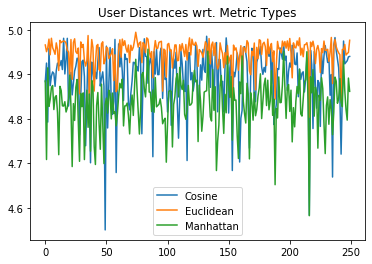

In [36]:
#Plot results
plt.plot(cos_sum, label = 'Cosine')
plt.plot(euc_sum, label = 'Euclidean')
plt.plot(mat_sum, label = 'Manhattan')
plt.title('User Distances wrt. Metric Types')
plt.legend()

The Manhattan distances in green consistently achieve lower average distance between the user and their top 5 peers, so Manhattan distance will be used for the remainder of the processes. 

In [37]:
#This function predicts rating for specified user-item combination 
def predict_userscore(user_id, item_id, ratings):
    prediction = 0
    similarities, indices = findksimilarusers(user_id, ratings, metric = 'manhattan') 
    mean_rating = ratings[user_id, :].data.mean()
    sum_wt = np.sum(similarities)-1
    product = 1
    wtd_sum = 0 
    
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == user_id:
            continue;
        else: 
            ratings_diff = ratings[indices.flatten()[i], item_id]-np.mean(ratings[indices.flatten()[i],:])
            product = ratings_diff * (similarities[i])
            wtd_sum = wtd_sum + product
    
    prediction = int(round(mean_rating + (wtd_sum/sum_wt)))
    print ('\nPredicted rating for user {0} -> item {1}: {2}'.format(user_id, item_id, prediction))
    result = mean_rating + (wtd_sum/sum_wt)
    return result
predict_userscore(9000, 232, users_and_books)

Five most similar users for User 9000:

1: User 30089, with similarity of 0.2912151176927301
2: User 39558, with similarity of 0.2650462366863673
3: User 52801, with similarity of 0.25031948894825307
4: User 44844, with similarity of 0.24567654201844302
5: User 33722, with similarity of 0.2423113664354084

Predicted rating for user 9000 -> item 232: 3


3.1800880601667716

In [38]:
#Suppress printed statements in subroutines
@contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [39]:
def recommend_userbased(user_id, ratings):
    prediction = []
    with suppress_stdout():
        for i in range(ratings.shape[1]):
            if ratings[user_id, i] != 0:
                prediction.append(predict_userscore(user_id, i, ratings))
            else:
                prediction.append(-1) #for pre-rated items

        prediction = pd.Series(prediction)
        prediction = prediction.sort_values(ascending = False)
        recs = prediction[:10]
        result = []
        for i in range(recs.shape[0]):
            result.append(books.title[recs.index[i]-1])
        return result
recommend_userbased(90, users_and_books)

['Naked',
 'Dress Your Family in Corduroy and Denim',
 'Holidays on Ice',
 'A Clockwork Orange',
 "Oh, The Places You'll Go!",
 'The Giver (The Giver, #1)',
 'Bossypants',
 "The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1)",
 'I Know Why the Caged Bird Sings',
 "The Handmaid's Tale"]

## Goodreads Web Scraper

In [40]:
# Function to find new book_ids
api_key= os.environ.get('GOODREADS_API_KEY')
api_secret= os.environ.get('GOODREADS_API_SECRET')

def get_pop_books(list_id):
    
    page = 1
    booklist = []
    #Iterate through first ten pages of popular book list
    while page:

        url = 'https://www.goodreads.com/list/show/{0}?page=' + str(++page)

        grURL = requests.get(url.format(list_id))
        grHTML = grURL.text

        soup = bs.BeautifulSoup(grHTML, 'html.parser')
        booklink = soup.find_all('a', attrs={'class': 'bookTitle'})
        for links in booklink:
            booklink = links['href'][11:]
            #Take book_id after period or hyphen, depending on format
            if '.' in booklink:
                booklink = int(booklink.split('.')[0])
            elif '-' in booklink:
                booklink = int(booklink.split('-')[0])
            booklist.append(booklink)
        page += 1
        #Break loop when there is no 'next_page' option
        if soup.find(class_='next_page disabled'):
            break
    #Check/remove preexisting titles before final
    booklist = [x for x in booklist if x not in books.best_book_id.values]
    return booklist


In [41]:
#Saved copy of get_pop_books(264)
booklist = pd.read_csv('booklist.csv')

#Fetch details per book
def get_book_details_by_id(goodreads_id):
    api_url = 'http://goodreads.com/book/show/{0}?format=xml&key={1}'
    r = requests.get(api_url.format(goodreads_id, api_key))
    try:
        book_data = xmltodict.parse(r.content)['GoodreadsResponse']['book']
    except (TypeError, KeyError, ExpatError):
        return False
    keys = ['authors', 'title', 'average_rating', 'ratings_count', 'image_url',
            'popular_shelves']
    book = {}
    for k in keys:
        book[k] = book_data.get(k)
    if type(book_data['authors']['author']) == list:
        authors = [author['name'] for author in book_data['authors']['author']]
        authors = ', '.join(authors)
    else:
        authors = book_data['authors']['author']['name']
    book['authors'] = authors
    
    #Find tag_names and create bag-of-words
    try: 
        some_frame = pd.Series(book['popular_shelves'])
        shelves = ' '.join([x['@name'] for x in some_frame[0]])

        #Remove to-read labels on each book
        shelves = shelves.replace('to-read ', '')
        book.update({'popular_shelves': shelves})
    except (TypeError, IndexError):
        return False
    book.update({'best_book_id': goodreads_id})   
    return book
get_book_details_by_id(2657)

{'authors': 'Harper Lee',
 'title': 'To Kill a Mockingbird',
 'average_rating': '4.27',
 'ratings_count': '4023262',
 'image_url': 'https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1553383690l/2657._SX98_.jpg',
 'popular_shelves': 'currently-reading classics favorites fiction classic historical-fiction books-i-own owned school favourites literature young-adult book-club historical novels read-for-school owned-books all-time-favorites re-read school-books for-school high-school coming-of-age to-buy american classic-literature favorite-books american-literature pulitzer novel adult ya my-books library literary-fiction favorite 1001-books adult-fiction my-library to-re-read english drama realistic-fiction audiobook pulitzer-prize modern-classics 5-stars audiobooks 20th-century general-fiction school-reads default reread southern read-in-2015 racism i-own my-favorites read-in-school history books classic-fiction childhood banned-books audio american-lit kindle read-aga

In [42]:
#Fetch details for groups of books
def get_new_books(num):
    new_titles = []
    #Init list of n books from popular book list
    while len(new_titles) < num:
        try:
            #Pick a book in popular book list 
            number = np.random.choice(booklist.iloc[:, 0].tolist())
            book = get_book_details_by_id(number)

            #Prune books with less reviews than original dataset minimum
            if int(book['ratings_count']) < 3000:
                continue
            else:
                print('New book found')
                new_titles.append(book)
        except (TypeError, KeyError, ExpatError):
            print('Error, moving on.')
            continue
    #Handle repeat entries from RNG
    new_titles = pd.DataFrame(new_titles)
    new_titles = new_titles.drop_duplicates()
    #Convert to original column names
    new_titles = new_titles.rename(columns={'popular_shelves':'tag_name', 
                                            'ratings_count':'work_ratings_count', 
                                           })
    return new_titles

In [43]:
#Add new books to original DF
new_books= get_new_books(5)
newest_books= books.append(new_books, ignore_index=True)
#Update new books to have book_id 1 higher than index
newest_books.book_id = newest_books.book_id.fillna(newest_books.index.to_series()+1)
#Display end of new DataFrame
newest_books.tail(10)

New book found
Error, moving on.
New book found
New book found
Error, moving on.
New book found
New book found


,authors,average_rating,best_book_id,book_id,goodreads_book_id,image_url,tag_name,title,work_id,work_ratings_count
9995,Ilona Andrews,4.09,7130616,9996.0,7130616.0,https://images.gr-assets.com/books/1307445460m...,urban-fantasy fantasy romance paranormal paran...,"Bayou Moon (The Edge, #2)",7392860.0,18856
9996,Robert A. Caro,4.25,208324,9997.0,208324.0,https://s.gr-assets.com/assets/nophoto/book/11...,biography history politics non-fiction current...,"Means of Ascent (The Years of Lyndon Johnson, #2)",1084709.0,12952
9997,Patrick O'Brian,4.35,77431,9998.0,77431.0,https://images.gr-assets.com/books/1455373531m...,historical-fiction fiction historical currentl...,The Mauritius Command,2393986.0,10733
9998,Peggy Orenstein,3.65,8565083,9999.0,8565083.0,https://images.gr-assets.com/books/1279214118m...,non-fiction nonfiction parenting feminism soci...,Cinderella Ate My Daughter: Dispatches from th...,13433613.0,11994
9999,John Keegan,4,8914,10000.0,8914.0,https://images.gr-assets.com/books/1403194704m...,history currently-reading non-fiction military...,The First World War,11817.0,9700
10000,"Diana Rowland, Daniel Dos Santos",3.93,9640626,10001.0,NaN,https://i.gr-assets.com/images/S/compressed.ph...,zombies urban-fantasy fantasy currently-readin...,My Life as a White Trash Zombie (White Trash Z...,NaN,10879
10001,"Hergé, Leslie Lonsdale-Cooper, Michael Tu...",4.26,146109,10002.0,NaN,https://i.gr-assets.com/images/S/compressed.ph...,comics graphic-novels tintin comic adventure b...,"Red Rackham's Treasure (Tintin, #12)",NaN,11014
10002,Julie Berry,3.92,17297487,10003.0,NaN,https://i.gr-assets.com/images/S/compressed.ph...,young-adult historical-fiction ya mystery curr...,All the Truth That's in Me,NaN,11349
10003,"Margaret Weis, Tracy Hickman",3.65,668860,10004.0,NaN,https://s.gr-assets.com/assets/nophoto/book/11...,fantasy dragonlance owned currently-reading fi...,The Second Generation (Dragonlance: The Second...,NaN,6402
10004,Tana French,3.77,2459785,10005.0,NaN,https://i.gr-assets.com/images/S/compressed.ph...,currently-reading mystery fiction thriller cri...,"In the Woods (Dublin Murder Squad, #1)",NaN,38754


In [44]:
#Scrape first 250 ratings of new books
def get_book_ratings_by_id(goodreads_id):
    api_url = 'http://goodreads.com/book/show/{0}?format=xml&key={1}'

    page = 1
    booklist = []
    users = []
    # Books in main DF have mean 250 ratings per title
    #Scrape first 250 ratings of popular book 
    while len(users) <250:

        url = 'https://www.goodreads.com/book/show/{0}?page=' + str(++page)

        grURL = requests.get(url.format(goodreads_id))
        grHTML = grURL.text

        soup = bs.BeautifulSoup(grHTML, 'html.parser')
        bookuser= soup.find_all('a', attrs={'class': 'user'})
        #Extract ids from html
        for link in bookuser:
            user = link['href'][11:]
            #Take book_id after period or hyphen, depending on format
            if '.' in user:
                user = int(user.split('.')[0])
            elif '-' in user:
                user = int(user.split('-')[0])
            users.append(user)
        bookratings = soup.find_all('span', attrs = {'class':'staticStars notranslate'})
        bookratings2 = soup.find_all(class_ = 'staticStars notranslate')
        ratings_dict = {'did not like it': 1, 'it was ok': 2, 
                        'liked it': 3, 'really liked it': 4,
                        'it was amazing' : 5}
        #Extract title and substitute rating
        for link in bookratings:
            rating = link['title']
            rating = ratings_dict[rating]
            #Take book_id after period or hyphen, depending on format
            booklist.append(rating)
        page += 1
        if page==10:
            break
        #Break loop when there is no 'next_page' option
        if soup.find(class_='next_page disabled'):
            break
    #Transform into user-rating pairs
    users = pd.Series(users)
    booklist = pd.Series(booklist)
    book_id = pd.Series([goodreads_id]*len(users))
    result = pd.concat([users, booklist, book_id], axis=1).rename(columns={0:'user_id', 1:'rating', 2:'best_book_id'})
    #Discard records without ratings
    result = result.dropna()
    result['rating'] = result['rating'].apply(lambda x: int(x))
    return result
get_book_ratings_by_id(2657)

,user_id,rating,best_book_id
0,1413439,5,2657
1,71848701,5,2657
2,520753,5,2657
3,2933855,5,2657
4,614778,5,2657
...,...,...,...
262,16737952,5,2657
263,22696175,4,2657
264,5789353,5,2657
265,6313408,5,2657


## MovieLens Web Scraper

In [45]:
#Import API Key from environment variables
movie_key = os.environ.get('TMDB_API_KEY')
movie_secret = os.environ.get('TMDB_API_TOKEN')

In [46]:
#Generate list of movie_ids to scrape
def get_top_movies():
    
    page = 1
    movielist = []
    #Iterate through first ten pages of popular movie list
    while page:
        
        url = 'https://www.themoviedb.org/movie?language=en-US&page=' + str(++page)
        
        grURL = requests.get(url)
        grHTML = grURL.text

        soup = BeautifulSoup(grHTML, 'html.parser')
        movielink = soup.find_all('a', attrs={'class': 'title result'})

        for link in movielink:
            movielink = link['href'][7:]
            movielink = int(movielink.split('?')[0])
            movielist.append(movielink)
            
        page += 1
        #Break loop when there is no 'next_page' option
        if soup.find(class_='next_page disabled'):
            break
        print('Page Number ' + str(page))
    #Check/remove preexisting titles before final
    movielist = [x for x in movielist if x not in metadata.id.values]
    return movielist

In [47]:
#Find new movie_ids within IMDB lists
def get_movies_from_list(list_id):
    
    url = 'http://api.themoviedb.org/3/list/{0}?api_key={1}&language=en-US'

    r = requests.get(url.format(list_id, movie_key))
    #Translate to json, extract names from dict
    try:
        movie_list = r.json()['items']
    except (TypeError, KeyError, ExpatError):
        return False
    movies = [item['id'] for item in movie_list]
    #Discard used movies
    movies = [x for x in movies if x not in metadata.id.values]
    return movies
get_movies_from_list(3)

[287947, 297802, 141052, 298622, 297797]

In [48]:
# Extract list of keywords 
def get_movie_keywords(tmdb_id):
    api_url = 'https://api.themoviedb.org/3/movie/{0}/keywords?api_key={1}'
    r = requests.get(api_url.format(tmdb_id, movie_key))
    #Translate to json, extract names from dict
    movie_keywords= r.json()
    movie_keywords = [i['name'] for i in movie_keywords['keywords']]
    return movie_keywords
get_movie_keywords(800)

['slum',
 'mexico',
 'mexico city',
 'homelessness',
 'fair',
 'delinquent',
 'approved school ',
 'teacher',
 'juvenile delinquent',
 'rebellious youth',
 'alcoholic',
 'older woman younger man relationship']

In [49]:
#Fetch details per movie
def get_movie_details_by_id(tmdb_id):
    api_url = 'https://api.themoviedb.org/3/movie/{0}?api_key={1}'
    r = requests.get(api_url.format(tmdb_id, movie_key))
    try:
        movie_data = r.json()
    except (TypeError, KeyError, ExpatError):
        return False
    keys = ['id', 'imdb_id', 'original_language',
            'title', 'genres', 'poster_path', 'popularity']
    movie = {}
    for k in keys:
        movie[k] = movie_data.get(k)
    #Find tag_names and create bag-of-words
    movie['genres'] = get_genres(movie['genres'])
    movie['genres'] = ' '.join(movie['genres'])
    try: 
        #Import keywords from previous function
        movie['keywords'] = get_movie_keywords(tmdb_id)
        movie['keywords'] = [x.replace(' ', '-') for x in movie['keywords']]
        movie['keywords'] = ' '.join(movie['keywords'])
    except KeyError:
        movie['keywords'] = ''
    #Discard untitled & adult films
    try:
        if (movie_data['title'] == None) | \
        (movie_data['adult'] != False) | \
        (movie_data['status'] != 'Released'):
            return False
    except KeyError:
        return False
    #Combine two columns into bag-of-words format
    movie.update({'genrekeys': movie['genres']+' ' +movie['keywords']})
    return movie
get_movie_details_by_id(890)

{'id': 890,
 'imdb_id': 'tt0114354',
 'original_language': 'de',
 'title': 'Brother of Sleep',
 'genres': 'Drama',
 'poster_path': '/wjvaafRCIGKLTJYm45oWgB494gJ.jpg',
 'popularity': 1.948,
 'keywords': 'suicide gay sibling-relationship sex lovesickness jealousy austria new-love village-life mountain-village pregnancy dying-and-death vorarlberg organ down-syndrome village music genius snow rural-area storm church alps-mountains catholicism',
 'genrekeys': 'Drama suicide gay sibling-relationship sex lovesickness jealousy austria new-love village-life mountain-village pregnancy dying-and-death vorarlberg organ down-syndrome village music genius snow rural-area storm church alps-mountains catholicism'}

In [50]:
def get_new_movies(num):
    
    new_titles=[]
    #List out results of new title search
    some_movies = new_movies.iloc[:, 0].tolist()
    
    #Init list of n movies from popular movie list
    while len(new_titles) < num:
        try:
            #Pick a movie in popular movie list 
            number = np.random.choice(some_movies)
            movie = get_movie_details_by_id(number)
            if movie== False:
                continue
            else:
                new_titles.append(movie)
        except (TypeError, KeyError, ExpatError, AttributeError):
            continue
    new_titles = pd.DataFrame(new_titles)
    #Eliminate duplicates from the RNG
    new_titles = new_titles.drop_duplicates().reset_index(drop=True)
    return new_titles

In [51]:
#Scrape new ratings from IMDB 
def get_movie_ratings_by_id(imdb_id):

    users = []
    ratingslist = []
    # movies in main DF have mean 250 ratings per title
    #Scrape first 250 ratings of popular movie 

    url = 'https://www.imdb.com/title/{0}/reviews?ref_=tt_urv' 
    res = requests.get(url.format(imdb_id))
    soup = BeautifulSoup(res.text,'lxml')

    #Selenium subscript for automating 'load page more' page scrolling
    driver = webdriver.Chrome(r'C:\Users\mcgow\Downloads\Chromedriver\chromedriver.exe')
    wait = WebDriverWait(driver,10)

    driver.get(url.format(imdb_id))
    soup = BeautifulSoup(driver.page_source, 'lxml')

    while True:
        try:
            driver.find_element_by_css_selector('button#load-more-trigger').click()
            wait.until(EC.invisibility_of_element_located((By.CSS_SELECTOR,'.ipl-load-more__load-indicator')))
            soup = BeautifulSoup(driver.page_source, 'lxml')
        except Exception:break


    driver.quit()
    # List all userIds
    mvURL = requests.get(url.format(imdb_id))
    mvHTML = mvURL.text
    movieuser = soup.find_all('span', attrs={'class': 'rating-other-user-rating'})
    movielist = [item.text for item in movieuser]
    movielist = [x.replace('\n', '').replace('/10', '') for x in movielist]


    for data in soup.find_all('span', class_='display-name-link'):
        for a in data.find_all('a'):
            #Clean slashes and extra letters
            link = a.get('href')[6:-13]
            users.append(link)
        #Stop when 250 reviews are scraped
        if len(users) == 250:
            break
            
    #Transform into user-rating-imdb_id triplets
    users = pd.Series(users)
    movielist = pd.Series(movielist)
    movie_id = pd.Series([imdb_id]*len(users))
    result = pd.concat([users, movielist, movie_id], axis=1).rename(columns={0:'user_id', 1:'rating', 2:'imdbId'})
    #Discard records without ratings
    result = result.dropna()
    result['rating'] = result['rating'].apply(lambda x: int(x))
    return result
get_movie_ratings_by_id('tt0114709')

,user_id,rating,imdbId
0,ur1002035,9,tt0114709
1,ur3922673,10,tt0114709
2,ur4445210,10,tt0114709
3,ur1173088,9,tt0114709
4,ur2446936,10,tt0114709
...,...,...,...
245,ur60223548,9,tt0114709
246,ur4112394,9,tt0114709
247,ur2898520,10,tt0114709
248,ur48290862,8,tt0114709


In [52]:
#Results of calling get_top_movies(): 2162 new titles
#New movie pipeline example
new_movies = pd.read_csv('new_movies.csv')
first3 = []
three_details = [get_movie_details_by_id(movie) for movie in new_movies.iloc[:3, 0].tolist()]
# Translate TMDB to IMDB ids for rating retrieval
three_ids = pd.DataFrame(three_details)['imdb_id'].tolist()
#Getting new ratings per IMDB_ids
for movie in three_ids:
    first3.append(get_movie_ratings_by_id(movie))
pd.concat(first3)

,user_id,rating,imdbId
0,ur107156609,8.0,tt3794354
1,ur67774980,8.0,tt3794354
2,ur113724100,10.0,tt3794354
3,ur69453412,8.0,tt3794354
4,ur113594588,10.0,tt3794354
...,...,...,...
245,ur110804304,4.0,tt2935510
246,ur39129851,10.0,tt2935510
247,ur111557849,10.0,tt2935510
248,ur15060576,8.0,tt2935510


# Conclusion

By combining the genres and keywords and finding similar matches via term frequency matrices, the similarity model is the first in its class to be able to effectively filter book content that resembles movies a user enjoys, and can even recommend other movies based on either content or user similarities. By adding weights to the most important words (genres), the model can recognize their increased significance and first find a match of film/book types before diving into more specific subject matter. 

## Further Research

By building a front end, users interacting with the website would provide valuable feedback information as to whether they enjoy the books recommended to them and reveal points where the model fails to capture highly similar matches. Additionally, the key piece of user-user collaborative filtering would be finally possible as the database of cross-platform users grow and digest new books, i.e. users will be able to submit their preferences for both movies and books to help establish which movies and books are commonly rated together by similar users. 

The demo will be available [here](movie2book.herokuapp.com) soon!